Structure of the paper will be as follows...

R2 - IS and OOS, boostrap errors.

New Loss function v random - IS and OOS, boostrap errors.

### 0.0 Inputs...

In [2]:
from __future__ import division, print_function

import joblib
import numpy as np
from IPython.display import SVG
from scipy.spatial.distance import pdist, squareform, jaccard, cityblock
from scipy import stats

from multiprocessing import Pool
from copy import deepcopy

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model as LM

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge, ElasticNet, Lasso

# Model dictionaries - we're just going to be looking at Ridge and Random Forest here.
model_dict = {'ridge' : {'m' : Ridge, 'kw' : {'fit_intercept':True, 'alpha':0.1}},
              'rf'    : {'m' : RandomForestRegressor, 'kw' : {'n_estimators':100, 'n_jobs':4, 'max_depth':10}}}

# Datasets
from glob import glob
targets = [s.replace('datasets/', '') for s in glob('datasets/*')]

import matplotlib.pyplot as plt
%pylab inline
figsize(20, 10)
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [7]:
# Pull in data for a single target name
def get_data(tgt_name='COX-2'):
    data_dir = 'datasets/' + tgt_name + '/'
    preds = joblib.load(data_dir + tgt_name + '_predsu.npy')
    resps = joblib.load(data_dir + tgt_name + '_respu.npy')
    smiles = joblib.load(data_dir + tgt_name + '.smiu')
    return preds, resps, smiles

## 1.0 Different models. R^2 loss

### 1.1  Insample

This is just a check of how R^2 does insample on the various models (currently just ridge and RF) that we examine. Obviously we expect RF to massively outperform Ridge given its ability to overfit...

In [4]:
def regress(response, pred_list, one=False, do_print=True):

    regr = LM.LinearRegression(fit_intercept=one)
    regr.fit(np.asarray(pred_list).swapaxes(0, 1), response)
    
    presp = regr.predict(np.asarray(pred_list).swapaxes(0, 1))
    r2 = r2_score(response, presp)
    if do_print:
        if one:
            rs = ('%6.4f '* (len(pred_list) + 1)) % (tuple(regr.coef_) + (regr.intercept_,))
        else:
            rs = ('%6.4f '* (len(pred_list)) % tuple(regr.coef_))
        print ('Coeffs:       ' + rs)
        print ('R-squared: {:9.4f}'.format(r2))
    else:
        return regr.coef_, r2

In [11]:
insample_rs_hdr = {}

for method in model_dict.keys():
    insample_rs_hdr[method] = []
    pass

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        mdl = model_dict[m]['m'](**model_dict[m]['kw'])
        mdl.fit(preds, resps)
        fc = mdl.predict(preds)
        
        beta, r2 = regress(resps, [fc,], do_print=False)
        insample_rs_hdr[m].append(np.sign(beta[0])*r2)
        pass
    pass

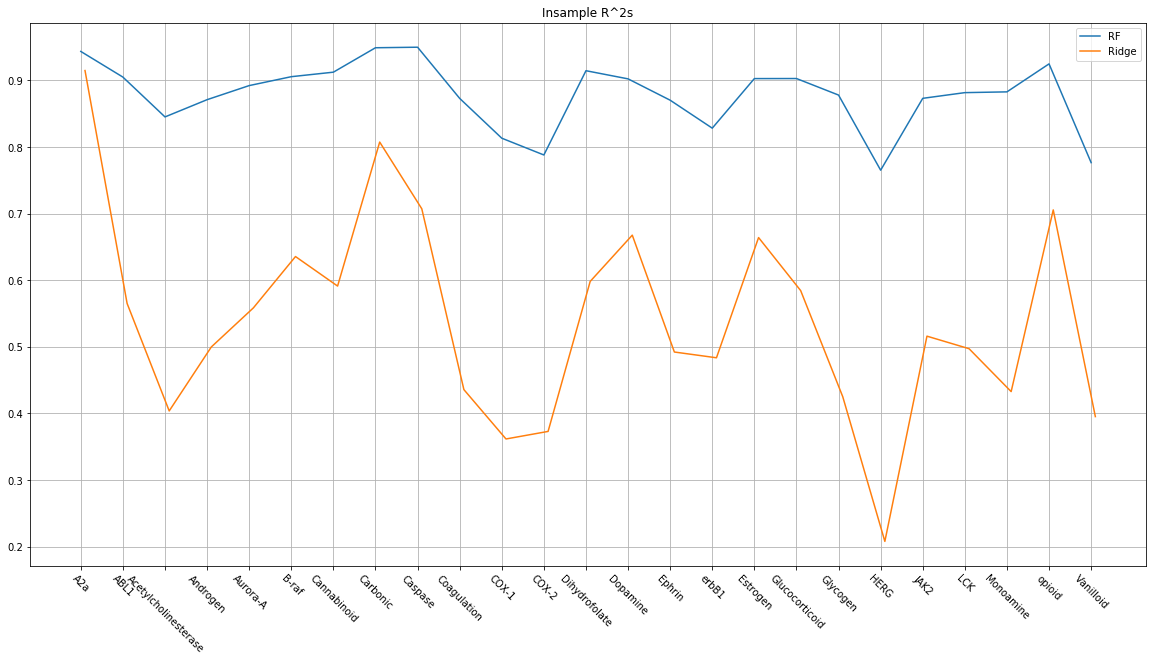

In [14]:
plot(np.arange(25), insample_rs_hdr['rf'],  label='RF')
plot(np.arange(25)+0.1, insample_rs_hdr['ridge'],  label='Ridge')
grid(True)
title('Insample R^2s')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

### 1.2 Out of sample (with bootstrap error bars)

In [56]:
def full_bootstrap(preds, resps, method, num_runs=100, do_print=True, frac_fit=1.0):

    r_2s = []
    betas = []
    sorted_indices = np.argsort(resps)

    N = len(resps)
    M = int(N * frac_fit)
    for i in range(num_runs):
        idcs_rand = np.random.choice(M, M)
        idcs = sorted_indices[idcs_rand]
        oos = np.delete(np.arange(N), idcs)
        
        mdl = model_dict[method]['m'](**model_dict[method]['kw'])
        mdl.fit(preds[idcs], resps[idcs])
        
        beta, r2 = regress(resps[oos], [mdl.predict(preds[oos]),], do_print=False, one=False)
        if beta < 0:
            r2 *= -1
            pass
        r_2s.append(r2)
        betas.append(beta)
        pass
    
    r_2s = np.asarray(r_2s)
    betas = np.asarray(betas)
    if do_print:
        print ('Beta:         %9.3f [%8.3f %8.3f] at 5pct conf' % 
               (np.median(betas), np.percentile(betas, 5), np.percentile(betas, 95)))
        print ('R2 (signed):  %9.3f [%8.3f %8.3f] at 5pct conf' % 
               (np.median(r_2s), np.percentile(r_2s, 5), np.percentile(r_2s, 95)))
        
    else:
        beta = np.median(betas)
        beta_l = np.percentile(betas, 5)
        beta_u = np.percentile(betas, 95)
        r2 = np.median(r_2s)
        r2_l = np.percentile(r_2s, 5)
        r2_u = np.percentile(r_2s,95)
        return {'beta' : beta, 'beta_l' : beta_l, 'beta_u' : beta_u, 
                'r2' : r2, 'r2_l' : r2_l, 'r2_u' : r2_u}

In [27]:
ks = ['beta', 'beta_l', 'beta_u', 'r2', 'r2_l', 'r2_u']

In [28]:
oos_rs_hdr = {m : {x : [] for x in ks} for m in model_dict.keys()}

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bootstrap(preds, resps, m, do_print=False)
        for k in ks:
            oos_rs_hdr[m][k].append(res[k])
            pass
        pass
    pass

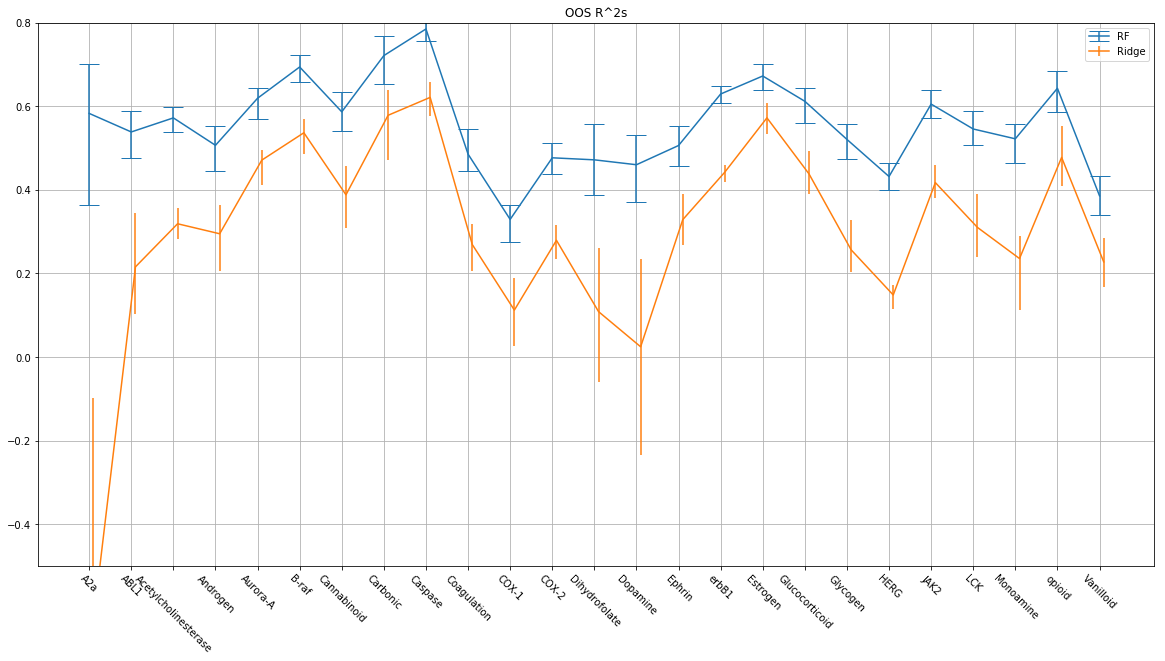

In [62]:
rf = np.asarray(oos_rs_hdr['rf']['r2'])
rdg = np.asarray(oos_rs_hdr['ridge']['r2'])

rfe = np.vstack((rf - np.asarray(oos_rs_hdr['rf']['r2_l']),
                 np.asarray(oos_rs_hdr['rf']['r2_u'])-rf))

rdge = np.vstack((rdg - np.asarray(oos_rs_hdr['ridge']['r2_l']) ,
                 np.asarray(oos_rs_hdr['ridge']['r2_u'])-rdg))

errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label='RF')
errorbar(np.arange(25)+0.1, rdg, yerr=rdge, label='Ridge')

grid(True)
title('OOS R^2s')
plt.xticks(np.arange(25), targets, rotation=-45)
plt.ylim((-0.5, .8))
legend(loc='best')

### Decreasing max activity in fit...

#### Max activity at 80%....

In [57]:
oos_rs_hdr_08 = {m : {x : [] for x in ks} for m in model_dict.keys()}

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bootstrap(preds, resps, m, do_print=False, frac_fit=0.8)
        for k in ks:
            oos_rs_hdr_08[m][k].append(res[k])
            pass
        pass
    pass

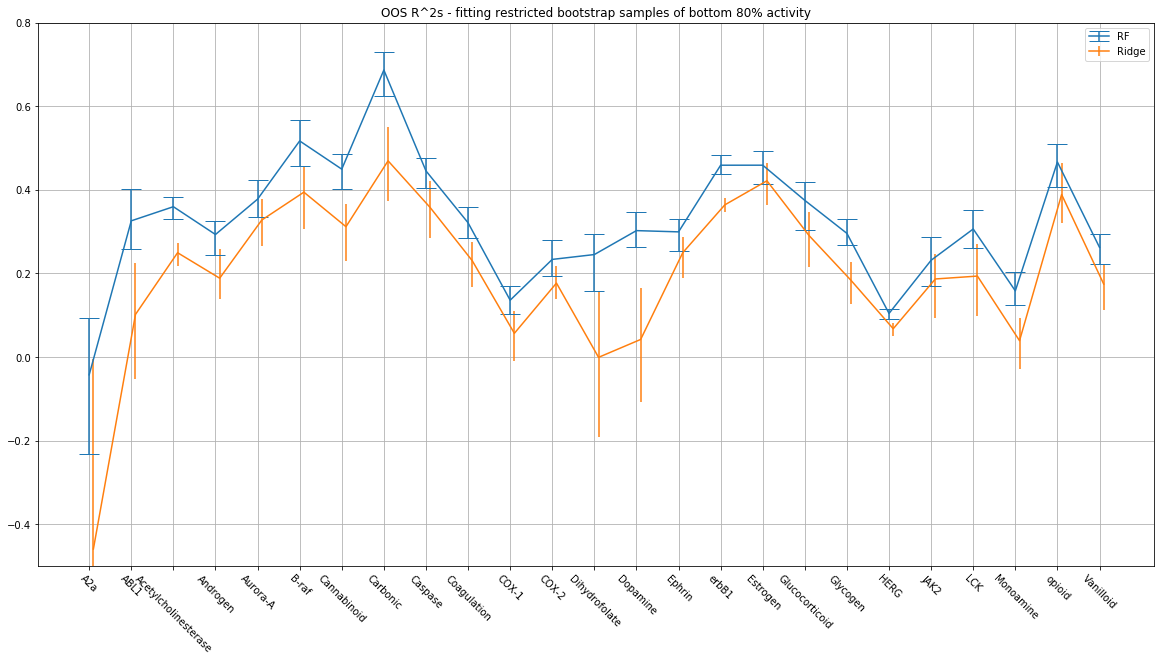

In [61]:
rf = np.asarray(oos_rs_hdr_08['rf']['r2'])
rdg = np.asarray(oos_rs_hdr_08['ridge']['r2'])

rfe = np.vstack((rf - np.asarray(oos_rs_hdr_08['rf']['r2_l']),
                 np.asarray(oos_rs_hdr_08['rf']['r2_u'])-rf))

rdge = np.vstack((rdg - np.asarray(oos_rs_hdr_08['ridge']['r2_l']) ,
                 np.asarray(oos_rs_hdr_08['ridge']['r2_u'])-rdg))

errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label='RF')
errorbar(np.arange(25)+0.1, rdg, yerr=rdge, label='Ridge')

grid(True)
title('OOS R^2s - fitting restricted bootstrap samples of bottom 80% activity')
plt.xticks(np.arange(25), targets, rotation=-45)
plt.ylim((-0.5, .8))
legend(loc='best')

#### Max activity at 60%...

In [63]:
oos_rs_hdr_06 = {m : {x : [] for x in ks} for m in model_dict.keys()}

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bootstrap(preds, resps, m, do_print=False, frac_fit=0.6)
        for k in ks:
            oos_rs_hdr_06[m][k].append(res[k])
            pass
        pass
    pass

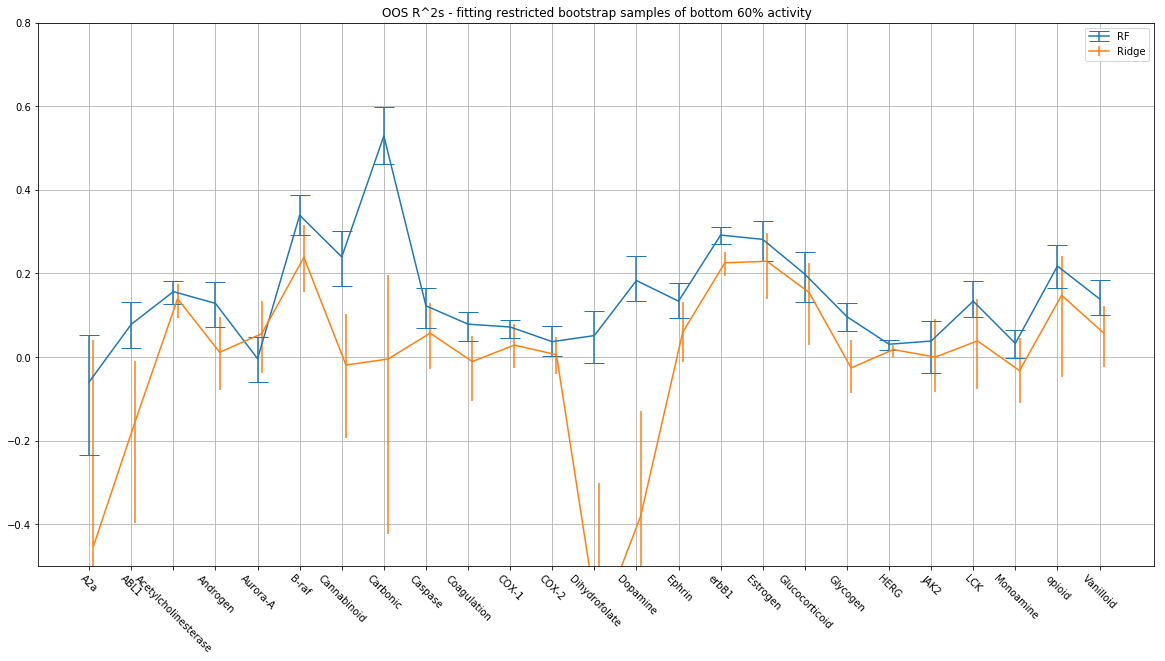

In [64]:
rf = np.asarray(oos_rs_hdr_06['rf']['r2'])
rdg = np.asarray(oos_rs_hdr_06['ridge']['r2'])

rfe = np.vstack((rf - np.asarray(oos_rs_hdr_06['rf']['r2_l']),
                 np.asarray(oos_rs_hdr_06['rf']['r2_u'])-rf))

rdge = np.vstack((rdg - np.asarray(oos_rs_hdr_06['ridge']['r2_l']) ,
                 np.asarray(oos_rs_hdr_06['ridge']['r2_u'])-rdg))

errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label='RF')
errorbar(np.arange(25)+0.1, rdg, yerr=rdge, label='Ridge')

grid(True)
title('OOS R^2s - fitting restricted bootstrap samples of bottom 60% activity')
plt.xticks(np.arange(25), targets, rotation=-45)
plt.ylim((-0.5, .8))
legend(loc='best')

In [69]:
frac_find = 0.9

insample_loss_hdr = {}

for method in model_dict.keys():
    insample_loss_hdr[method] = []
    pass

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    N = len(resps)
    tgt_val = np.percentile(resps, frac_find*100)
    
    for m in model_dict.keys():
        mdl = model_dict[m]['m'](**model_dict[m]['kw'])
        mdl.fit(preds, resps)
        predictions = mdl.predict(preds)
        ranked = np.argsort(-predictions)
        found = resps[ranked] >= tgt_val
        loss = np.mean(np.arange(N)[found])*2/N
        
        insample_loss_hdr[m].append(loss)
        pass
    pass

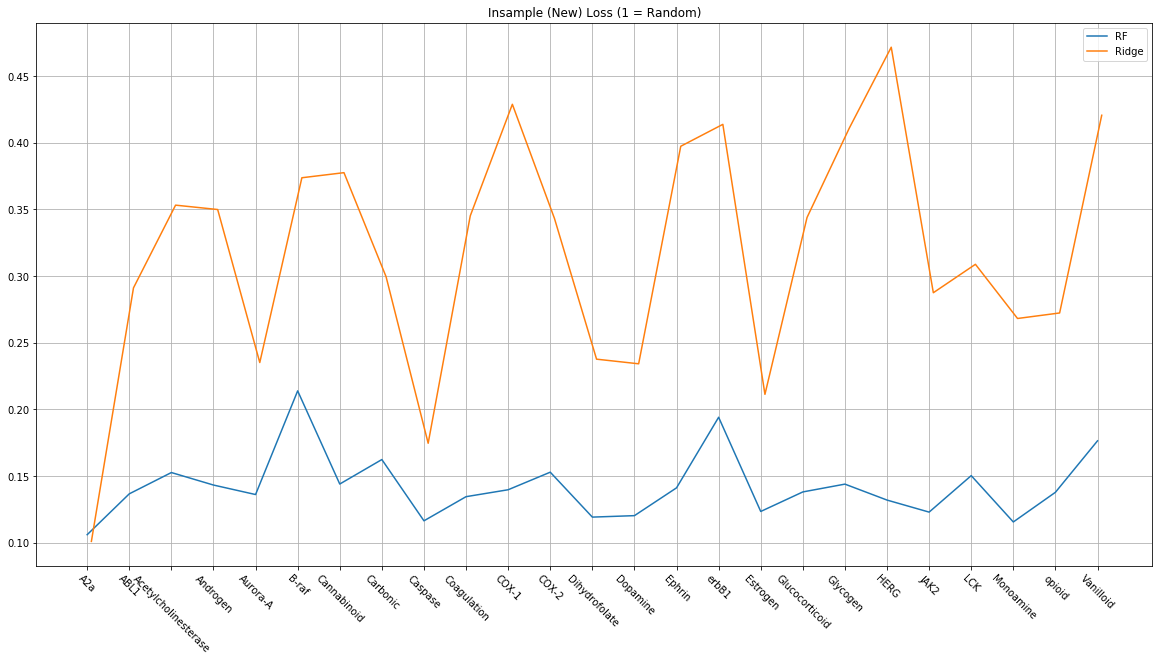

In [72]:
plot(np.arange(25), insample_loss_hdr['rf'],  label='RF')
plot(np.arange(25)+0.1, insample_loss_hdr['ridge'],  label='Ridge')
grid(True)
title('Insample (New) Loss (1 = Random)')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

In [76]:
def full_bs_new_loss(preds, resps, method, num_runs=100, do_print=True, frac_fit=1.0, frac_find=0.9):

    losses = []
    sorted_indices = np.argsort(resps)

    N = len(resps)
    M = int(N * frac_fit)
    n = int(N*frac_find)
    tgt_val = resps[sorted_indices[n]]
    
    for i in range(num_runs):
        idcs_rand = np.random.choice(M, M)
        idcs = sorted_indices[idcs_rand]
        oos = np.delete(np.arange(N), idcs)
        
        mdl = model_dict[method]['m'](**model_dict[method]['kw'])
        mdl.fit(preds[idcs], resps[idcs])
        
        #beta, r2 = regress(resps[oos], [mdl.predict(preds[oos]),], do_print=False, one=False)

        predictions = mdl.predict(preds[oos])
        ranked = oos[np.argsort(-predictions)]
        found = resps[ranked] >= tgt_val
            
        # LOSS (so small values are good) is the mean rank of the good molecules in the order
        # you rank them vs random (in which case the mean value would be half the length of the array)
        loss = np.mean(np.arange(len(oos))[found])*2/len(oos)
        
        losses.append(loss)
        
    losses = np.asarray(losses)
    
    if do_print:
        print ('Loss:  %9.3f [%8.3f %8.3f] at 5pct conf' % 
               (np.median(losses), np.percentile(losses, 5), np.percentile(losses, 95)))
        
    else:
        loss = np.median(losses)
        loss_l = np.percentile(losses, 5)
        loss_u = np.percentile(losses, 95)
        return {'loss' : loss, 'loss_l' : loss_l, 'loss_u' : loss_u}

In [74]:
%pdb on

Automatic pdb calling has been turned ON


In [77]:
lks = ['loss', 'loss_l', 'loss_u']

oos_loss_hdr = {m : {x : [] for x in lks} for m in model_dict.keys()}

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bs_new_loss(preds, resps, m, do_print=False)
        for k in lks:
            oos_loss_hdr[m][k].append(res[k])
            pass
        pass
    pass

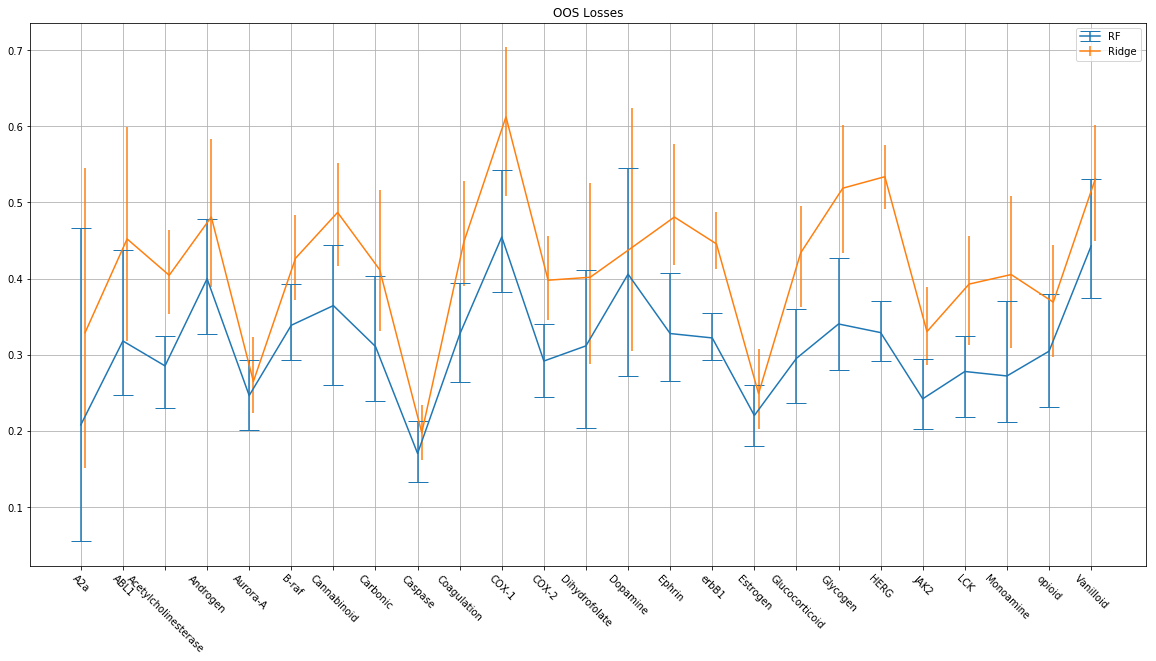

In [80]:
rf = np.asarray(oos_loss_hdr['rf']['loss'])
rdg = np.asarray(oos_loss_hdr['ridge']['loss'])

rfe = np.vstack((rf - np.asarray(oos_loss_hdr['rf']['loss_l']),
                 np.asarray(oos_loss_hdr['rf']['loss_u'])-rf))

rdge = np.vstack((rdg - np.asarray(oos_loss_hdr['ridge']['loss_l']) ,
                 np.asarray(oos_loss_hdr['ridge']['loss_u'])-rdg))

errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label='RF')
errorbar(np.arange(25)+0.1, rdg, yerr=rdge, label='Ridge')

grid(True)
title('OOS Losses')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

In [82]:
lks = ['loss', 'loss_l', 'loss_u']

oos_loss_hdr_09 = {m : {x : [] for x in lks} for m in model_dict.keys()}

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bs_new_loss(preds, resps, m, do_print=False, frac_fit=0.9)
        for k in lks:
            oos_loss_hdr_09[m][k].append(res[k])
            pass
        pass
    pass

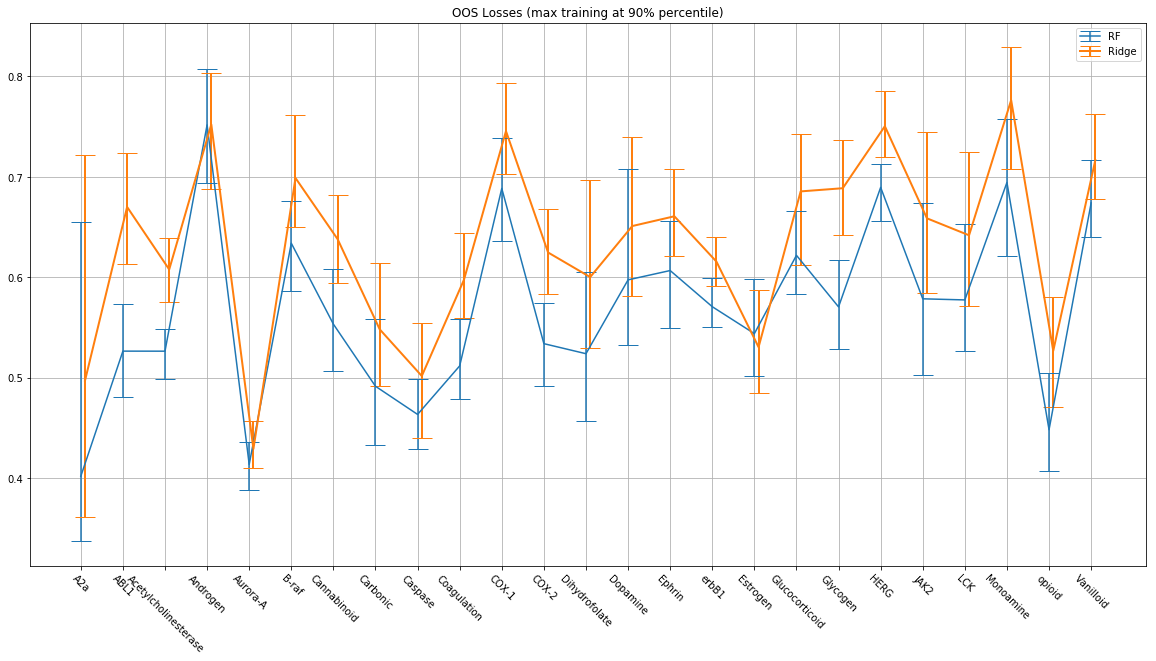

In [92]:
rf = np.asarray(oos_loss_hdr_09['rf']['loss'])
rdg = np.asarray(oos_loss_hdr_09['ridge']['loss'])

rfe = np.vstack((rf - np.asarray(oos_loss_hdr_09['rf']['loss_l']),
                 np.asarray(oos_loss_hdr_09['rf']['loss_u'])-rf))

rdge = np.vstack((rdg - np.asarray(oos_loss_hdr_09['ridge']['loss_l']) ,
                 np.asarray(oos_loss_hdr_09['ridge']['loss_u'])-rdg))

errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label='RF')
errorbar(np.arange(25)+0.1, rdg, yerr=rdge, label='Ridge', capsize=10, linewidth=2)

grid(True)
title('OOS Losses (max training at 90% percentile)')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

In [84]:
oos_loss_hdr_08 = {m : {x : [] for x in lks} for m in model_dict.keys()}

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bs_new_loss(preds, resps, m, do_print=False, frac_fit=0.8)
        for k in lks:
            oos_loss_hdr_08[m][k].append(res[k])
            pass
        pass
    pass

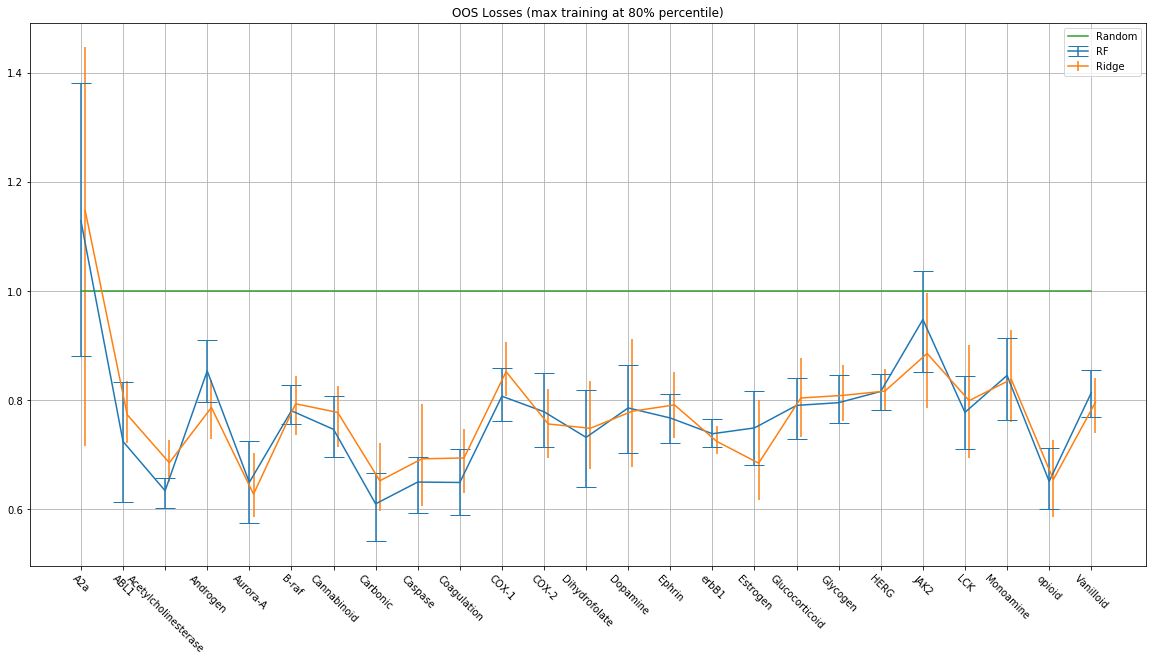

In [86]:
rf = np.asarray(oos_loss_hdr_08['rf']['loss'])
rdg = np.asarray(oos_loss_hdr_08['ridge']['loss'])

rfe = np.vstack((rf - np.asarray(oos_loss_hdr_08['rf']['loss_l']),
                 np.asarray(oos_loss_hdr_08['rf']['loss_u'])-rf))

rdge = np.vstack((rdg - np.asarray(oos_loss_hdr_08['ridge']['loss_l']) ,
                 np.asarray(oos_loss_hdr_08['ridge']['loss_u'])-rdg))

errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label='RF')
errorbar(np.arange(25)+0.1, rdg, yerr=rdge, label='Ridge')
plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('OOS Losses (max training at 80% percentile)')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

In [87]:
oos_loss_hdr_06 = {m : {x : [] for x in lks} for m in model_dict.keys()}

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bs_new_loss(preds, resps, m, do_print=False, frac_fit=0.6)
        for k in lks:
            oos_loss_hdr_06[m][k].append(res[k])
            pass
        pass
    pass

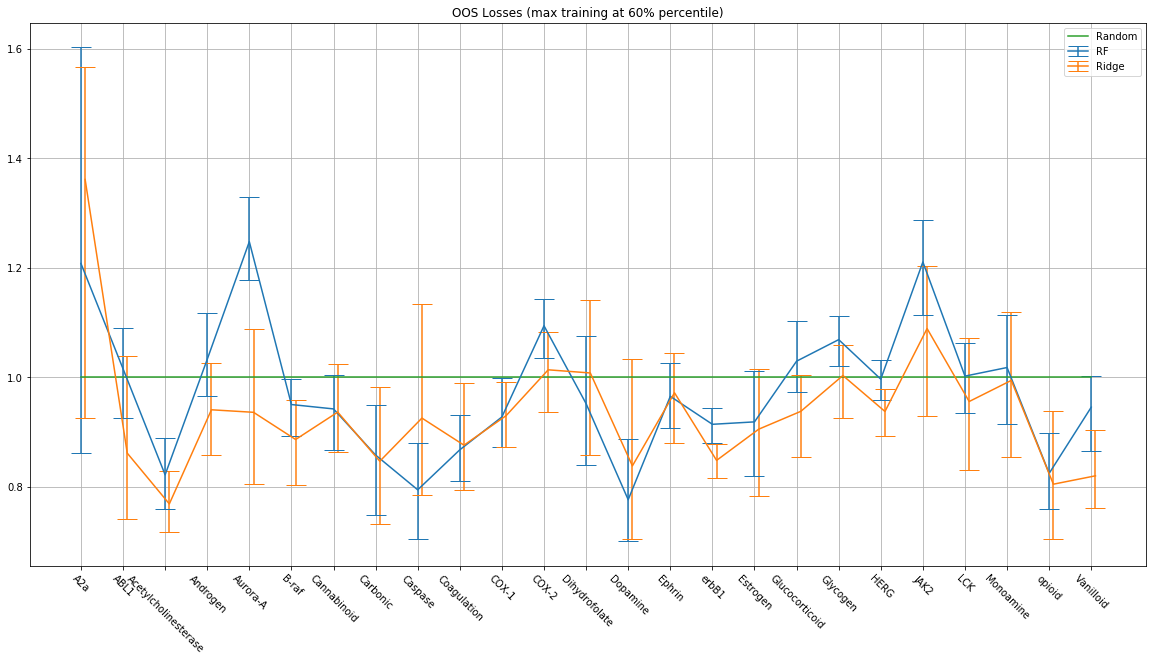

In [88]:
rf = np.asarray(oos_loss_hdr_06['rf']['loss'])
rdg = np.asarray(oos_loss_hdr_06['ridge']['loss'])

rfe = np.vstack((rf - np.asarray(oos_loss_hdr_06['rf']['loss_l']),
                 np.asarray(oos_loss_hdr_06['rf']['loss_u'])-rf))

rdge = np.vstack((rdg - np.asarray(oos_loss_hdr_06['ridge']['loss_l']) ,
                 np.asarray(oos_loss_hdr_06['ridge']['loss_u'])-rdg))

errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label='RF')
errorbar(np.arange(25)+0.1, rdg, yerr=rdge, label='Ridge', capsize=10)
plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('OOS Losses (max training at 60% percentile)')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

In [89]:
oos_loss_hdr_04 = {m : {x : [] for x in lks} for m in model_dict.keys()}

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bs_new_loss(preds, resps, m, do_print=False, frac_fit=0.4)
        for k in lks:
            oos_loss_hdr_04[m][k].append(res[k])
            pass
        pass
    pass

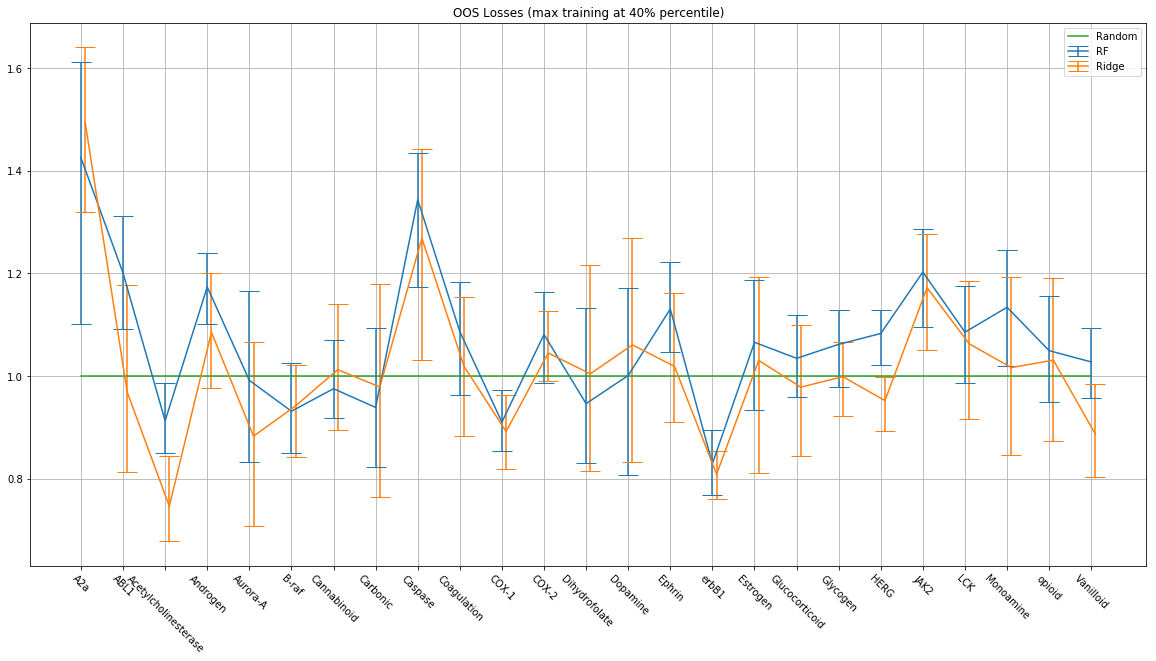

In [90]:
rf = np.asarray(oos_loss_hdr_04['rf']['loss'])
rdg = np.asarray(oos_loss_hdr_04['ridge']['loss'])

rfe = np.vstack((rf - np.asarray(oos_loss_hdr_04['rf']['loss_l']),
                 np.asarray(oos_loss_hdr_04['rf']['loss_u'])-rf))

rdge = np.vstack((rdg - np.asarray(oos_loss_hdr_04['ridge']['loss_l']) ,
                 np.asarray(oos_loss_hdr_04['ridge']['loss_u'])-rdg))

errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label='RF')
errorbar(np.arange(25)+0.1, rdg, yerr=rdge, label='Ridge', capsize=10)
plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('OOS Losses (max training at 40% percentile)')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

Let's compare the log likelihoods of the two models (vs random) assuming independence of datasets (also - since loss function is not distributed perfectly normally, when better than random we will use the upper error estimate, when worse than random we will use the lower error estimate, and when the random line (1.0) lies within the error estimates we will use the average...

In [101]:
def ll_estimate(loss_hdr):
    
    for method in model_dict.keys():
        vals = np.asarray(loss_hdr[method]['loss'])
        upper = np.asarray(loss_hdr[method]['loss_u'])
        lower = np.asarray(loss_hdr[method]['loss_l'])
        
        sigma = vals * np.nan
        # recall - these are 5% conf intervals, i.e. 2-sigma error bars
        sigma[upper < 1.] = ((upper - vals) / 2.)[upper < 1.]  
        sigma[lower > 1.] = ((vals - lower) / 2.)[lower > 1.]
        sigma[np.isnan(sigma)] = ((upper - lower) / 4.)[np.isnan(sigma)]
        assert((sigma > 0).all())
        
        dists = (vals - 1) / sigma
        ll = np.sum(np.sign(dists) * dists*dists) / 2.
        print('%10s  %9.3f' % (method, ll))
    
    return

In [102]:
ll_estimate(oos_loss_hdr)

        rf  -7403.383
     ridge  -4359.108


In [103]:
ll_estimate(oos_loss_hdr_09)

        rf  -5898.665
     ridge  -3452.097


In [104]:
ll_estimate(oos_loss_hdr_08)

        rf  -1491.811
     ridge   -935.068


In [105]:
ll_estimate(oos_loss_hdr_06)

        rf    -40.176
     ridge   -119.216


In [106]:
ll_estimate(oos_loss_hdr_04)

        rf     33.263
     ridge    -36.204


Awesome - we have the answer.  Ridge starts to beat random forest once you're extrapolating from below70% to try and get the top 90%...